In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
summary = pd.read_csv("atusdata/atussum_2013.dat")
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 36.0 MB


In [5]:
summary.columns

Index(['tucaseid', 'TUFINLWGT', 'TRYHHCHILD', 'TEAGE', 'TESEX', 'PEEDUCA',
       'PTDTRACE', 'PEHSPNON', 'GTMETSTA', 'TELFS', 
       ...
       't181501', 't181599', 't181601', 't181801', 't189999', 't500101',
       't500103', 't500105', 't500106', 't500107'],
      dtype='object', length=413)

Pertinent columns:

* TUFINLWGT - statistical weight of respondent
* TRYHHCHILD - age of youngest child in household (-1 means no children)
* TEAGE - age of respondent
* TESEX - sex of respondent
* TELFS - working status of respondent
* TRCHILDNUM - number of children in household

In [6]:
summary.head()

,tucaseid,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,...,t181501,t181599,t181601,t181801,t189999,t500101,t500103,t500105,t500106,t500107
0,20130101130004,11899905.662034,12,22,2,40,8,2,1,5,...,0,0,0,0,0,0,0,0,0,0
1,20130101130112,4447638.009513,1,39,1,43,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,20130101130123,10377056.507734,-1,47,2,40,1,2,1,4,...,25,0,0,0,0,0,0,0,0,0
3,20130101130611,7731257.992805,-1,50,2,40,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,20130101130616,4725269.227067,-1,45,2,40,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
cps = pd.read_csv("atusdata/atuscps_2013.dat")
cps = cps[cps.TULINENO == 1]

In [8]:
summary_cps = pd.merge(summary, cps, how="inner", left_on="tucaseid", right_on="TUCASEID")
summary_cps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 788 entries, tucaseid to PRDASIAN
dtypes: float64(3), int64(785)
memory usage: 68.5 MB


Merged the summary data with the cps report line 1 for each case id, which is the line for the survey respondant. Using cps to get marital status.

In [11]:
adults_crit = summary_cps.TEAGE >= 18
child_crit = summary_cps.TEAGE < 18
no_children_crit = summary_cps.TRCHILDNUM == 0
with_children_crit = summary_cps.TRCHILDNUM > 0
men_crit = summary_cps.TESEX == 1
women_crit = summary_cps.TESEX == 2
married_crit = summary_cps.PEMARITL.isin([1, 2]) 
divorced_crit = summary_cps.PEMARITL.isin([4, 5]) 
single_crit = summary_cps.PEMARITL.isin([3, 4, 5, 6])
never_married_crit = summary_cps.PEMARITL == 6
millenials_crit_1 = summary_cps.TEAGE <= 29
gen_x_crit_1 = summary_cps.TEAGE > 29
gen_x_crit_2 = summary_cps.TEAGE < 49
boomers_crit_1 = summary_cps.TEAGE >= 49
boomers_crit_2 = summary_cps.TEAGE <= 67

# Demographic Groups

In [12]:
adults = summary_cps[adults_crit]
children = summary_cps[child_crit]
people_no_children = summary_cps[no_children_crit]
people_with_children = summary_cps[with_children_crit]
men = summary_cps[men_crit]
women = summary_cps[women_crit]
men_no_children = summary_cps[men_crit & no_children_crit]
men_with_children = summary_cps[men_crit & with_children_crit]
women_no_children = summary_cps[women_crit & no_children_crit]
women_with_children = summary_cps[women_crit & with_children_crit]
married = summary_cps[married_crit]
divorced = summary_cps[divorced_crit]
single = summary_cps[single_crit]
never_married = summary_cps[never_married_crit]
married_with_children = summary_cps[married_crit & with_children_crit]
married_no_children = summary_cps[married_crit & no_children_crit]
single_with_children = summary_cps[single_crit & with_children_crit]
single_no_children = summary_cps[single_crit & no_children_crit]
millenials = summary_cps[adults_crit & millenials_crit_1]
gen_x = summary_cps[gen_x_crit_1 & gen_x_crit_2]
boomers = summary_cps[boomers_crit_1 & boomers_crit_2]

In [13]:
def activity_columns(data, activity_code):
    """For the activity code given, return all columns that fall under that activity."""
    col_prefix = "t{}".format(activity_code)
    return [column for column in data.columns if re.match(col_prefix, column)]

def average_minutes(data, activity_code):
    cols = activity_columns(data, activity_code)
    activity_data = data[cols]
    activity_sums = activity_data.sum(axis=1)
    data = data[['TUFINLWGT']]
    data['minutes'] = activity_sums
    data = data.rename(columns={"TUFINLWGT": "weight"})
    data['weighted_minutes'] = data.weight * data.minutes
    return data.weighted_minutes.sum() / data.weight.sum()

In [15]:
def activity_present(data, activity_code, minutes):
    cols = activity_columns(data, activity_code)
    data["sum"] = data[cols].sum(axis=1)
    activity_data = data[data["sum"] >= minutes]
    return activity_data.drop("sum", axis=1)

def no_activity(data, activity_code):
    cols = activity_columns(data, activity_code)
    data["sum"] = data[cols].sum(axis=1)
    activity_data = data[data["sum"] == 0]
    return activity_data.drop("sum", axis=1)

These two functions allow me to pass in a dataframe and activity code, along with a certain number of minutes for a threshold in the first function, and get a new dataframe of just those people who meet the criteria (above a certain number of minutes in that activity for activity_present and zero minutes of that activity for no_activity). For example, below I'll use the activity_present function to find all the people who responded that they spend 60 minutes or more in religious or spiritual activity, because 60 minutes is well above the survey average.

In [30]:
all_religion = average_minutes(summary_cps, "14")
men_religion = average_minutes(men, "14")
women_religion = average_minutes(women, "14")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
religion_by_sex = pd.Series({"Men": men_religion, "Women": women_religion})

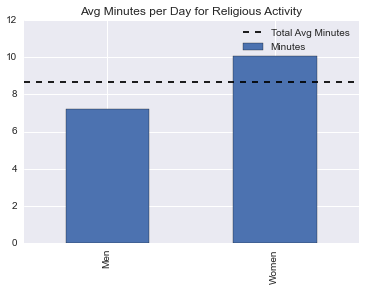

In [138]:
religion_by_sex.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Religious Activity")
plt.hlines(all_religion, xmin=-1, xmax=12, linestyle="dashed", label="Total Avg Minutes")
plt.legend()
plt.show()

This graph shows the average minutes per day in religious activity for men and women. Note that women spend more time engaging in religious or spiritual activity than men (about 10 minutes per day compared to just over 7 minutes per day).

In [33]:
millenials_religion = average_minutes(millenials, "14")
gen_x_religion = average_minutes(gen_x, "14")
boomers_religion = average_minutes(boomers, "14")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
religion_by_age = pd.Series({"Millenials": millenials_religion, "Gen X": gen_x_religion, "Boomers": boomers_religion})

In [71]:
#religion_by_age.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Religious Activity", figsize=(8, 5))
#plt.hlines(all_religion, xmin=-1, xmax=12, linestyle="dashed", label="Total Avg Minutes")
#plt.legend()
#plt.show()

# Gender/Age Demographics

In [36]:
men_millenials = summary_cps[men_crit & adults_crit & millenials_crit_1]
women_millenials = summary_cps[women_crit & adults_crit & millenials_crit_1]
men_gen_x = summary_cps[men_crit & gen_x_crit_1 & gen_x_crit_2]
women_gen_x = summary_cps[women_crit & gen_x_crit_1 & gen_x_crit_2]
men_boomers = summary_cps[men_crit & boomers_crit_1 & boomers_crit_2]
women_boomers = summary_cps[women_crit & boomers_crit_1 & boomers_crit_2]

In [37]:
men_mill_religion = average_minutes(men_millenials, "14")
women_mill_religion = average_minutes(women_millenials, "14")
men_genx_religion = average_minutes(men_gen_x, "14")
women_genx_religion = average_minutes(women_gen_x, "14")
men_boomers_religion = average_minutes(men_boomers, "14")
women_boomers_religion = average_minutes(women_boomers, "14")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [63]:
mmrel = {"Gender": "Men", "Age Group": "Millenials", "Religious Activity": men_mill_religion}
wmrel = {"Gender": "Women", "Age Group": "Millenials", "Religious Activity": women_mill_religion}
mxrel = {"Gender": "Men", "Age Group": "Gen X", "Religious Activity": men_genx_religion}
wxrel = {"Gender": "Women", "Age Group": "Gen X", "Religious Activity": women_genx_religion}
mbrel = {"Gender": "Men", "Age Group": "Boomers", "Religious Activity": men_boomers_religion}
wbrel = {"Gender": "Women", "Age Group": "Boomers", "Religious Activity": women_boomers_religion}
mfmrel = {"Gender": "Both", "Age Group": "Millenials", "Religious Activity": millenials_religion}
mfxrel = {"Gender": "Both", "Age Group": "Gen X", "Religious Activity": gen_x_religion}
mfbrel = {"Gender": "Both", "Age Group": "Boomers", "Religious Activity": boomers_religion}
religion_agemf = pd.DataFrame([mmrel, wmrel, mxrel, wxrel, mbrel, wbrel, mfmrel, mfxrel, mfbrel])

In [64]:
religion_table = pd.pivot_table(religion_agemf, values="Religious Activity", index="Age Group", columns="Gender")

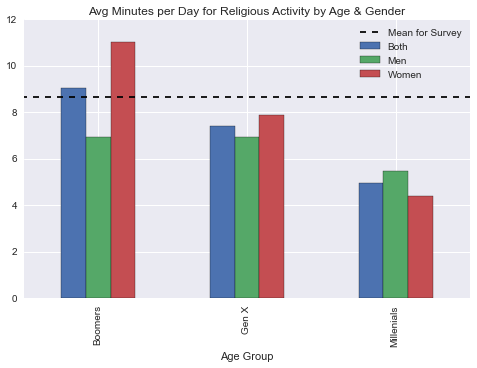

In [66]:
religion_table.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Religious Activity by Age & Gender", figsize=(8, 5))
plt.hlines(all_religion, xmin=-1, xmax=12, linestyle="dashed", label="Mean for Survey")
plt.legend()
plt.show()

We see from this graph that women in the baby boomers age group spend more time, on average, engaging in religious or spiritual activity than any other age or gender group. The baby boomer generation also shows the greatest difference by gender, as women outpaced men by quite a bit. While both men and women in the millenials generation are pretty far below the mean for the survey, men in that age group spend more time than women in religious activity. This is the opposite of the overall trend of women typically spending more time than men in religious activity (seen in the graph above).

# Marital Status/Age Demographics

In [47]:
married_millenials = summary_cps[married_crit & adults_crit & millenials_crit_1]
single_millenials = summary_cps[single_crit & adults_crit & millenials_crit_1]
married_gen_x = summary_cps[married_crit & gen_x_crit_1 & gen_x_crit_2]
single_gen_x = summary_cps[single_crit & gen_x_crit_1 & gen_x_crit_2]
married_boomers = summary_cps[married_crit & boomers_crit_1 & boomers_crit_2]
single_boomers = summary_cps[single_crit & boomers_crit_1 & boomers_crit_2]

In [52]:
marr_mill_religion = average_minutes(married_millenials, "14")
sin_mill_religion = average_minutes(single_millenials, "14")
marr_genx_religion = average_minutes(married_gen_x, "14")
sin_genx_religion = average_minutes(single_gen_x, "14")
marr_boomers_religion = average_minutes(married_boomers, "14")
sin_boomers_religion = average_minutes(single_boomers, "14")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [69]:
marr_mill_rel = {"Marital Status": "Married", "Age Group": "Millenials", "Religious Activity": marr_mill_religion}
sin_mill_rel = {"Marital Status": "Single", "Age Group": "Millenials", "Religious Activity": sin_mill_religion}
marr_x_rel = {"Marital Status": "Married", "Age Group": "Gen X", "Religious Activity": marr_genx_religion}
sin_x_rel = {"Marital Status": "Single", "Age Group": "Gen X", "Religious Activity": sin_genx_religion}
marr_boom_rel = {"Marital Status": "Married", "Age Group": "Boomers", "Religious Activity": marr_boomers_religion}
sin_boom_rel = {"Marital Status": "Single", "Age Group": "Boomers", "Religious Activity": sin_boomers_religion}
both_mill_rel = {"Marital Status": "Total", "Age Group": "Millenials", "Religious Activity": millenials_religion}
both_x_rel = {"Marital Status": "Total", "Age Group": "Gen X", "Religious Activity": gen_x_religion}
both_boom_rel = {"Marital Status": "Total", "Age Group": "Boomers", "Religious Activity": boomers_religion}
religion_agemarital = pd.DataFrame([marr_mill_rel, sin_mill_rel, marr_x_rel, sin_x_rel, marr_boom_rel, sin_boom_rel, both_mill_rel, both_x_rel, both_boom_rel])
religmarital_table = pd.pivot_table(religion_agemarital, values="Religious Activity", index="Age Group", columns="Marital Status")

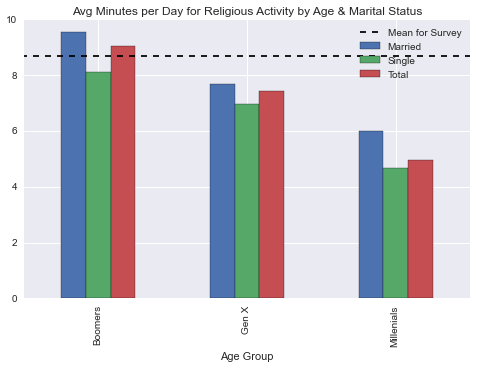

In [70]:
religmarital_table.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Religious Activity by Age & Marital Status", figsize=(8, 5))
plt.hlines(all_religion, xmin=-1, xmax=12, linestyle="dashed", label="Mean for Survey")
plt.legend()
plt.show()

For all three age groups, married people spend more time than single people engaging in religious and spiritual activity. The difference seems to be greatest among the millenials generation.

In [57]:
marr_child_religion = average_minutes(married_with_children, "14")
marr_nochild_religion = average_minutes(married_no_children, "14")
sing_child_religion = average_minutes(single_with_children, "14")
sing_nochild_religion = average_minutes(single_no_children, "14")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [61]:
marr_child_rel = {"Marital Status": "Married", "Children": "With Children", "Religious Activity": marr_child_religion}
marr_nochild_rel = {"Marital Status": "Married", "Children": "No Children", "Religious Activity": marr_nochild_religion}
sing_child_rel = {"Marital Status": "Single", "Children": "With Children", "Religious Activity": sing_child_religion}
sing_nochild_rel = {"Marital Status": "Single", "Children": "No Children", "Religious Activity": sing_nochild_religion}
religion_marrchild = pd.DataFrame([marr_child_rel, marr_nochild_rel, sing_child_rel, sing_nochild_rel])
religmarrchild_table = pd.pivot_table(religion_marrchild, values="Religious Activity", index="Marital Status", columns="Children")

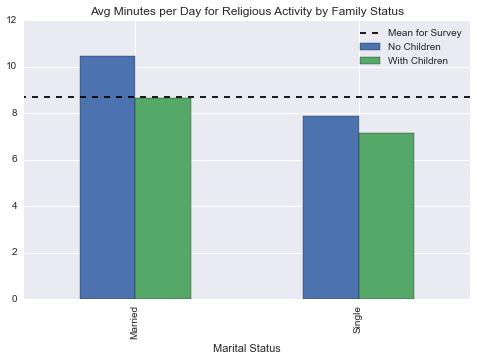

In [73]:
religmarrchild_table.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Religious Activity by Family Status", figsize=(8, 5))
plt.hlines(all_religion, xmin=-1, xmax=12, linestyle="dashed", label="Mean for Survey")
plt.legend()
plt.show()

Married people without children spend more time in religious activity than married people with children or either single group.

# Comparing Habits of Religious People & Non-Religious People

In [139]:
religious_adults = activity_present(adults, "14", 60)
non_relig_adults = no_activity(adults, "14")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Above, I've created two dataframes. One is the group of respondants who said they spent more than 60 minutes engaging in religious activity. This is the group referred to as the 'religious people.' The other group, the 'non-religious people,' are those who responded with 0 minutes per day in religious or spiritual activity. Below we'll look at comparisons of how these groups spend their leisure time, along with the overall averages, to see if there are any differences in the groups.

In [92]:
avg_reading = average_minutes(adults, "120312")
avg_thinking = average_minutes(adults, "120301")
avg_tobacco = average_minutes(adults, "120302")
avg_tel_mov = average_minutes(adults, "120303")
avg_rel_tel = average_minutes(adults, "120304")
avg_radio = average_minutes(adults, "120305")
avg_music = average_minutes(adults, "120306")
avg_games = average_minutes(adults, "120307")
avg_computer = average_minutes(adults, "120308")
avg_arts_crafts = average_minutes(adults, "120309")
avg_collecting = average_minutes(adults, "120310")
avg_hobbies = average_minutes(adults, "120311")
avg_writing = average_minutes(adults, "120313")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [93]:
rel_reading = average_minutes(religious_adults, "120312")
rel_thinking = average_minutes(religious_adults, "120301")
rel_tobacco = average_minutes(religious_adults, "120302")
rel_tel_mov = average_minutes(religious_adults, "120303")
rel_rel_tel = average_minutes(religious_adults, "120304")
rel_radio = average_minutes(religious_adults, "120305")
rel_music = average_minutes(religious_adults, "120306")
rel_games = average_minutes(religious_adults, "120307")
rel_computer = average_minutes(religious_adults, "120308")
rel_arts_crafts = average_minutes(religious_adults, "120309")
rel_collecting = average_minutes(religious_adults, "120310")
rel_hobbies = average_minutes(religious_adults, "120311")
rel_writing = average_minutes(religious_adults, "120313")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [95]:
no_rel_reading = average_minutes(non_relig_adults, "120312")
no_rel_thinking = average_minutes(non_relig_adults, "120301")
no_rel_tobacco = average_minutes(non_relig_adults, "120302")
no_rel_tel_mov = average_minutes(non_relig_adults, "120303")
no_rel_rel_tel = average_minutes(non_relig_adults, "120304")
no_rel_radio = average_minutes(non_relig_adults, "120305")
no_rel_music = average_minutes(non_relig_adults, "120306")
no_rel_games = average_minutes(non_relig_adults, "120307")
no_rel_computer = average_minutes(non_relig_adults, "120308")
no_rel_arts_crafts = average_minutes(non_relig_adults, "120309")
no_rel_collecting = average_minutes(non_relig_adults, "120310")
no_rel_hobbies = average_minutes(non_relig_adults, "120311")
no_rel_writing = average_minutes(non_relig_adults, "120313")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [132]:
all_read = {"Group": "All", "Leisure Time": "Reading", "Minutes": avg_reading}
rel_read = {"Group": "Religious People", "Leisure Time": "Reading", "Minutes": rel_reading}
non_rel_read = {"Group": "Non-Religious People", "Leisure Time": "Reading", "Minutes": no_rel_reading}
all_think = {"Group": "All", "Leisure Time": "Relaxing Thinking", "Minutes": avg_thinking}
rel_think = {"Group": "Religious People", "Leisure Time": "Relaxing Thinking", "Minutes": rel_thinking}
non_rel_think = {"Group": "Non-Religious People", "Leisure Time": "Relaxing Thinking", "Minutes": no_rel_thinking}
all_tobac = {"Group": "All", "Leisure Time": "Tobacco & Drug Use", "Minutes": avg_tobacco}
rel_tobac = {"Group": "Religious People", "Leisure Time": "Tobacco & Drug Use", "Minutes": rel_tobacco}
non_rel_tobac = {"Group": "Non-Religious People", "Leisure Time": "Tobacco & Drug Use", "Minutes": no_rel_tobacco}
all_telmov = {"Group": "All", "Leisure Time": "Television & Movies", "Minutes": avg_tel_mov}
rel_telmov = {"Group": "Religious People", "Leisure Time": "Television & Movies", "Minutes": rel_tel_mov}
non_rel_telmov = {"Group": "Non-Religious People", "Leisure Time": "Television & Movies", "Minutes": no_rel_tel_mov}
all_reltel = {"Group": "All", "Leisure Time": "Religious Television", "Minutes": avg_rel_tel}
rel_reltel = {"Group": "Religious People", "Leisure Time": "Religious Television", "Minutes": rel_rel_tel}
non_rel_reltel = {"Group": "Non-Religious People", "Leisure Time": "Religious Television", "Minutes": no_rel_rel_tel}
all_radiouse = {"Group": "All", "Leisure Time": "Radio", "Minutes": avg_radio}
rel_radiouse = {"Group": "Religious People", "Leisure Time": "Radio", "Minutes": rel_radio}
non_rel_radiouse = {"Group": "Non-Religious People", "Leisure Time": "Radio", "Minutes": no_rel_radio}
all_musicuse = {"Group": "All", "Leisure Time": "Music (Non-Radio)", "Minutes": avg_music}
rel_musicuse = {"Group": "Religious People", "Leisure Time": "Music (Non-Radio)", "Minutes": rel_music}
non_rel_musicuse = {"Group": "Non-Religious People", "Leisure Time": "Music (Non-Radio)", "Minutes": no_rel_music}
all_game = {"Group": "All", "Leisure Time": "Games", "Minutes": avg_games}
rel_game = {"Group": "Religious People", "Leisure Time": "Games", "Minutes": rel_games}
non_rel_game = {"Group": "Non-Religious People", "Leisure Time": "Games", "Minutes": no_rel_games}
all_comp = {"Group": "All", "Leisure Time": "Computer (excluding games)", "Minutes": avg_computer}
rel_comp = {"Group": "Religious People", "Leisure Time": "Computer (excluding games)", "Minutes": rel_computer}
non_rel_comp = {"Group": "Non-Religious People", "Leisure Time": "Computer (excluding games)", "Minutes": no_rel_computer}
all_artscrafts = {"Group": "All", "Leisure Time": "Arts & Crafts", "Minutes": avg_arts_crafts}
rel_artscrafts = {"Group": "Religious People", "Leisure Time": "Arts & Crafts", "Minutes": rel_arts_crafts}
non_rel_artscrafts = {"Group": "Non-Religious People", "Leisure Time": "Arts & Crafts", "Minutes": no_rel_arts_crafts}
#all_collect = {"Group": "All", "Leisure Time": "Collecting", "Minutes": avg_collecting}
#rel_collect = {"Group": "Religious People", "Leisure Time": "Collecting", "Minutes": rel_collecting}
#non_rel_collect = {"Group": "Non-Religious People", "Leisure Time": "Collecting", "Minutes": no_rel_collecting}
all_hobby = {"Group": "All", "Leisure Time": "Hobbies", "Minutes": avg_hobbies}
rel_hobby = {"Group": "Religious People", "Leisure Time": "Hobbies", "Minutes": rel_hobbies}
non_rel_hobby = {"Group": "Non-Religious People", "Leisure Time": "Hobbies", "Minutes": no_rel_hobbies} 
all_write = {"Group": "All", "Leisure Time": "Writing", "Minutes": avg_writing}
rel_write = {"Group": "Religious People", "Leisure Time": "Writing", "Minutes": rel_writing}
non_rel_write = {"Group": "Non-Religious People", "Leisure Time": "Writing", "Minutes": no_rel_writing}

leisure_time_1 = pd.DataFrame([all_read, rel_read, non_rel_read, all_think, rel_think, non_rel_think, all_game, rel_game, non_rel_game, all_comp, rel_comp, non_rel_comp])
leisure_table_1 = pd.pivot_table(leisure_time_1, values="Minutes", index="Leisure Time", columns="Group")
leisure_time_2 = pd.DataFrame([all_reltel, rel_reltel, non_rel_reltel, all_tobac, rel_tobac, non_rel_tobac, all_radiouse, rel_radiouse, non_rel_radiouse, all_musicuse, rel_musicuse, non_rel_musicuse, all_artscrafts, rel_artscrafts, non_rel_artscrafts, all_hobby, rel_hobby, non_rel_hobby, all_write, rel_write, non_rel_write])
leisure_table_2 = pd.pivot_table(leisure_time_2, values="Minutes", index="Leisure Time", columns="Group")
leisure_time_3 = pd.DataFrame([all_telmov, rel_telmov, non_rel_telmov])
leisure_table_3 = pd.pivot_table(leisure_time_3, values="Minutes", index="Leisure Time", columns="Group")

The graphs below show the average minutes spent in various leisure activities for the two groups established above: religious people (more than 60 minutes per day in religious activity), and non-religious people (0 minutes per day in religious activity). Note that the group of religious people is much smaller, around 1000 people, than the non-religious group, around 9000 people. Also note that the activities are grouped in separate graphs so that the minutes scale is similar for each particular graph (i.e. the Television & Movie numbers are so large that it makes the other numbers difficult to see if included in the same graph, especially the one with Hobbies, Writing, and Tobacco & Drug Use).

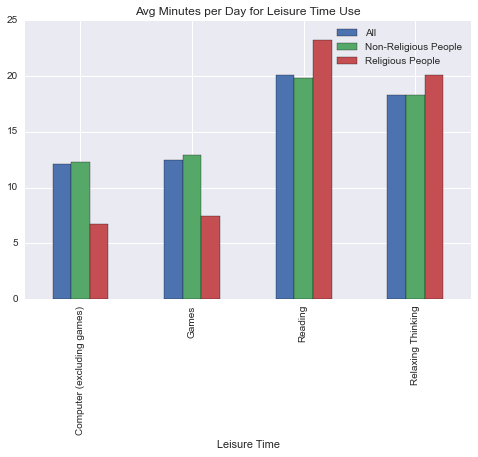

In [133]:
leisure_table_1.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Leisure Time Use", figsize=(8, 5))
plt.legend()
plt.show()

Above we see that, on average, religious people tend to spend less of their leisure time on the computer or playing games, and more of their leisure time reading or engaging in relaxing thinking. However, the actual differences in the number of minutes is pretty small, as is the total number of minutes spent in these activities for any group.

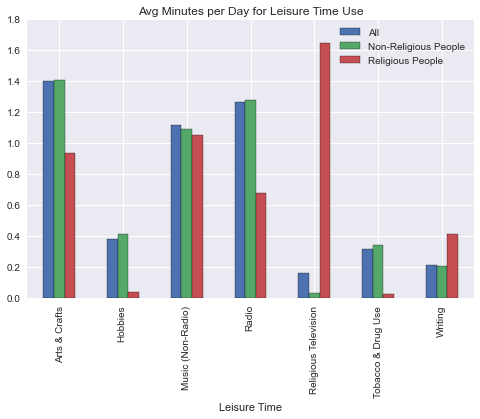

In [140]:
leisure_table_2.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Leisure Time Use", figsize=(8, 5))
plt.legend()
plt.show()

The first thing to note here is the minutes scale on the left - all of these leisure time activities are engaged in on a very limited basis (less than 2 minutes per day on average). However, we can notes some more differences between religious and non-religious people. Religious people are much more likely to spend time watching religious television, which makes sense. They also spend more time writing for leisure than non-religious people. They tend to spend less time on arts and crafts or other hobbies, less time listing to the radio, and less time in tobacco or drug use.

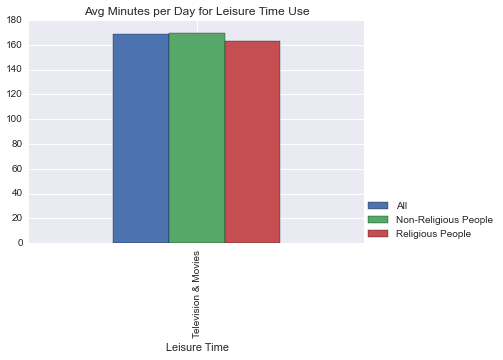

In [137]:
leisure_table_3.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Leisure Time Use")
plt.legend(loc=(1, 0))
plt.show()

Time spent watching television and movies is on a separate graph because it dwarfs all of the other activites above in terms of how much time people spend on average in that activity. The activity with the second highest average of time spent is reading at only 20 minutes per day, while television and movies averages nearly 3 hours per day. We can see that there is a slight difference when comparing the two groups, but it doesn't appear to be very significant.